# Régularisation en deep learning ☕️☕️

In [1]:
book=True

Les techniques de régularisation sont fondamentales en *machine learning*. Elles nous permettent de considérer des classes de fonctions complexes tout en favorisant certaines solutions dont on sait qu'elles auront tendances à être plus stables et à mieux généraliser à de nouvelles données. Les régularisations peuvent être explicites comme au travers de l'usage d'une pénalité $\ell_1$ ou $\ell_2$ comme nous avons pu le voir. Elles peuvent êtres implicites en résultant par exemple d'un effet de bord de l'optimiseur comme nous le verrons plus bas.

Le *deep learning* offre tout un ensemble de stratégies qu'on ne retrouve pas systématiquement ailleurs. Cela est dû à la structure même de ces fonctions mais aussi au types de tâches et de données qu'elles permettent de traiter avec succès. Cette séquence est donc consacrée aux méthodes de régularisations utilisées en *deep learning*.

Toute cette séquence considérera $\mathcal{X}$ comme étant l'espace des données d'entrée, $\mathcal{Y}$ celui de nos labels et $S_n=\{(x_i, y_i)\}_{i\leq n}$ notre jeu de données d'apprentissage et $T_n=\{(x_i, y_i)\}_{i\leq m}$ notre jeu de test.

## I. Régularisation de la norme du vecteur de paramètres

De la même manière que pour d'autres approches de *machine learning*, les réseaux de neurones en étant des familles paramétriques de fonctions peuvent être pénalisés au travers de l'apprentissage. Notons $L(\theta, S_n)$ la *loss* à optimiser sur notre jeu de données $S_n$ où $\theta$ est une paramétrisation donnée de notre modèle. Nous définissons notre *loss* régularisée de manière très standard de la manière suivante :
$$\tilde{L}(\theta, S_n)=L(\theta, S_n)+\lambda P(\theta),$$
où $\lambda > 0$ contre la quantité de régularisation souhaitée. 
### A. La régularisation $\ell_2$, *weight decay* ou encore *Ridge*
La régularisation $\ell_2$ est peut-être la régularisation explicite la plus transversalement adoptée. Dans ce cas de figure la pénalité n'est autre que la norme $\ell_2$ de notre vecteur de paramètres :
$$P(\theta)=\frac{1}{2}\lVert\theta\rVert_2^2,$$
où le $1/2$ n'a aucun intérêt autre que calculatoire. Une séquence complète sera dédiée à cette régularisation. Pour l'instant, observons intuitivement l'effet de cette dernière.
\begin{equation}
\begin{aligned}
\nabla \tilde{L}(\theta, S_n)&=\nabla L(\theta, S_n)+ \nabla\frac{\lambda}{2}\lVert\theta\rVert_2^2\\
&=\nabla L(\theta, S_n)+\lambda \theta
\end{aligned}
\end{equation}

Rappelons nous que le pas de descente de gradient est donné par :
$$\theta^{t+1}=\theta^t-\eta\nabla \tilde{L}(\theta^t)$$
où $\eta>0$ est le pas d'apprentissage. On obtient donc dans le cas d'une pénalité $\ell_2$ le pas d'optimisation suivant :
$$\theta^{t+1}=(1-\eta\lambda)\theta^t-\eta\nabla L(\theta^t, S_n), $$

où on observe qu'avant même de se déplacer dans la direction de la plus forte pente ($-\nabla$), notre vecteur de paramètre se voit contracté par la pénalité $\lambda$.

*La pénalité $\ell_2$ étant standard à beaucoup de modèles, n'hésitez pas à vous référer aux autres séquences afin d'approfondir le sujet*

Considérons le jeu de données suivant et construisons un réseau de neurones.

In [24]:
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import transforms
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [8]:
if not book:
    # label names
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    transform = transforms.Compose(
      [
          transforms.ToTensor(),
          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
      ]
    )

    batch_size = 128

    #root_directory where images are.
    trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

    trainloader = DataLoader(
      trainset, batch_size=batch_size
    )

    testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    testloader = DataLoader(
      testset, batch_size=batch_size, shuffle=True
    )

    print('Nb test batchs:', len(testloader))

Files already downloaded and verified
Files already downloaded and verified
Nb test batchs: 79


In [9]:
def imshow(images, labels, predicted=None):
    plt.figure(figsize=(15, 10))
    for idx in range(8):
        plt.subplot(2, 4, idx+1)
        plt.axis('off')
        img = (images[idx] * 0.224 + 0.456)#/ 2 + 0.5  # unnormalize
        npimg = img.numpy()
        plt.axis('off')
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        title = str(classes[labels[idx]]) + \
        ('' if predicted is None else ' - ' + str(classes[predicted[idx]]))
        plt.title(title)
        
    plt.show()

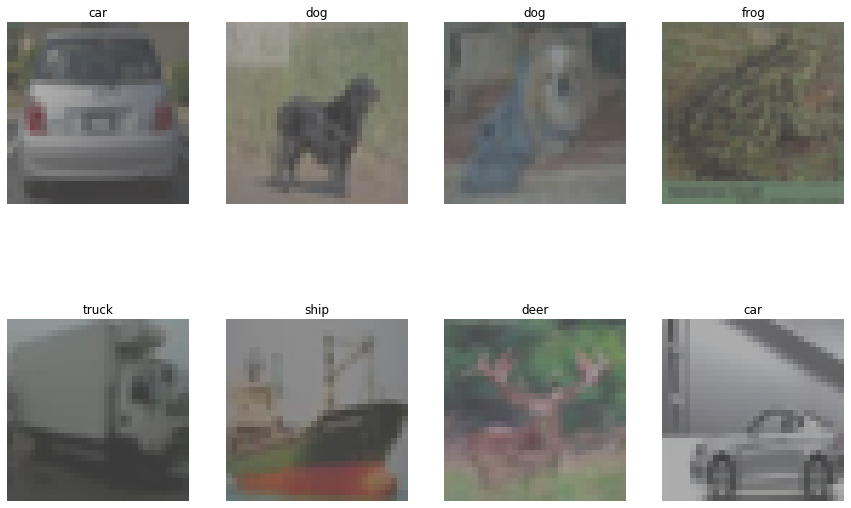

In [10]:
if not book:
    dataiter = iter(testloader)
    images, labels = dataiter.next()

    # show images
    imshow(images[:8], labels[:8])

Et maintenant, construisons un réseau de neurones :

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc(x)
        return x

Et configurons notre optimisation.

In [13]:
criterion = nn.CrossEntropyLoss()

In [19]:
def train(model, criterion, optimizer, n_epoch=2, eval_frequency=2):
    loss_history = []
    valid_loss_history = []

    acc_history = []
    val_acc_history = []

    for epoch in range(n_epoch):  # loop over the dataset multiple times
        print("[EPOCH %d, LR: %s]"%(epoch + 1, str(0.01)))

        #iterate over the training batches until all all samples have been considered
        model.train()
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            if i % 5 == 4:
                print('\r[Batch id: %d/%d]' % (i+1, len(trainloader)), end='')
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # Convert to cuda is device is gpu
            # inputs = inputs.cuda()
            # labels = labels.cuda()

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward : compute outputs for all layers 
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Backward: Compute gradient wrt parameters of all layers
            loss.backward()


            optimizer.step()

        print(' train loss: %.3f' % (running_loss/len(trainloader)))


        if (epoch + 1) % eval_frequency == 0:
            #Compute training statistics
            accuracy_train = test(model, trainloader, 'train')
            accuracy_test = test(model, testloader, 'test')
            loss_train = loss_eval(model, trainloader, 'train')
            loss_test = loss_eval(model, testloader, 'test')
            loss_history.append(loss_train)
            acc_history.append(accuracy_train)
            valid_loss_history.append(loss_test)
            val_acc_history.append(accuracy_test)

        print("\n")

    print('**** Finished Training ****')
    return loss_history, val_acc_history

In [21]:
def test(model, loader, title):
    model.eval()  # on passe le modele en mode evaluation
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            # images = images.cuda()
            # labels = labels.cuda()
            outputs = model(images)
            predicted = torch.nn.functional.softmax(outputs, dim=1).max(dim=1)
            
            total += labels.size(0)
            correct += (predicted[1] == labels).sum().item()
            
    model.train()  # on remet le modele en mode apprentissage
    print('Accuracy du modele sur le jeu de ', title, ': %.2f' % (correct / total))
    return correct / total
  
def loss_eval(model, loader, title):
    model.eval()  # on passe le modele en mode evaluation
    running_loss = 0.
    total = 0.
    with torch.no_grad():
        for data in loader:
            images, labels = data
            # images = images.cuda()
            # labels = labels.cuda()
            outputs = model(images)

            total += 1.
            running_loss += criterion(outputs, labels).item()

    model.train()  # on remet le modele en mode apprentissage
    print('Loss du modele sur le jeu de ', title, ': %.2f' % (running_loss / total))
    return (running_loss / total)



In [22]:
def plot_loss(loss_history, valid_loss_history, acc_history, val_acc_history):
    plt.figure()
    plt.plot([i*eval_frequency for i in range(1, len(loss_history)+1)], loss_history, 
             label='Train loss')
    plt.plot([i*eval_frequency for i in range(1, len(loss_history)+1)], valid_loss_history, 
             label='Validation loss')
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot([i*eval_frequency for i in range(1, len(acc_history)+1)], acc_history, 
             label='Train Accuracy')
    plt.plot([i*eval_frequency for i in range(1, len(acc_history)+1)], val_acc_history, 
             label='Validation Accuracy')
    plt.legend()
    plt.show()

---
<span style="color:blue">**Exercice :**</span> **La pénalité $\ell_2$ s'appelle *weight decay* en *deep learning* et est configurable directement au niveau de l'optimiseur. Testez-en les effets avec le code ci-dessous.**

---

In [23]:
if not book:
    model = Net()
    # model = model.cuda()

    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)

    eval_frequency=2

    loss_history, \
    valid_loss_history, \
    acc_history, \
    val_acc_history = train(model, criterion, optimizer, n_epoch=30)

[EPOCH 1, LR: 0.01]
[Batch id: 390/391] train loss: 2.000


[EPOCH 2, LR: 0.01]
[Batch id: 390/391] train loss: 1.509


NameError: name 'torch' is not defined

In [2]:
if not book:
    plot_loss(loss_history, val_acc_history)

NameError: name 'plot_loss' is not defined

### B. La régularisation $\ell_1$ ou *Lasso*

## II. *Early stopping*

## III. La *data augmentation*

Nous avons déjà vu lors de séquences précédentes que lorsque la quantité de données était trop limitée nous pouvions régulariser notre modèle. Une stratégie de régularisation devient donc de créer des images de manière bien choisie afin d'augmenter virtuellement la taille de notre jeu de données et de stabiliser notre optimisation tout en choisissant les paramétrisations les plus parcimonieuses. La *data augmentation* est une des stratégies les plus courantes et standards utilisées en *deep learning*.

Nous allons nous concentrer ici sur le cas où les données à perturber sont des images. Intuitivement, si je fais une petite rotation d'une image de chat, celle-ci sera toujours une image de chat et les pixels de la nouvelle image seront significativement différents des pixels de l'ancienne image : nous avons donc bien une nouvelle image. L'idée va être de chercher à construire des perturbations qui conservent la sémantique de l'image (i.e. l'objet qu'elle représente).

In [1]:
from PIL import Image
import matplotlib.pyplot as plt

L'image est téléchargeable à l'adresse suivante : 
[lemon.jpeg](https://raw.githubusercontent.com/maximiliense/lmiprp/main/Travaux%20Pratiques/Machine%20Learning/Introduction/data/Adversarial/lemon.jpeg).

In [3]:
image = Image.open('lemon.jpeg')

plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.axis('off')
plt.show()

NameError: name 'Image' is not defined

La librairie $\text{pytorch}$ offre déjà un certain nombre de transformations possibles de nos données. En voici quelques exemples : 

In [3]:
from torchvision import transforms

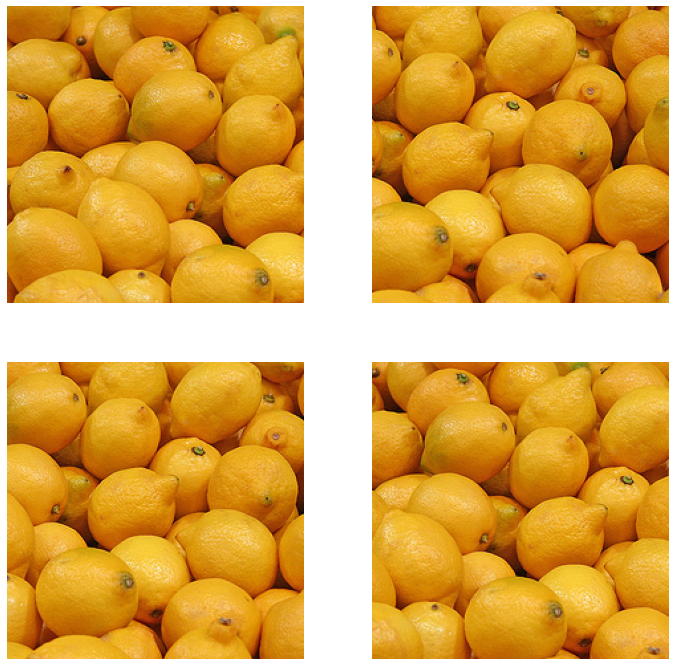

In [4]:
crops = [transforms.RandomCrop(224)(image) for _ in range(4)]

plt.figure(figsize=(12, 12))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(crops[i])
    plt.axis('off')

plt.show()

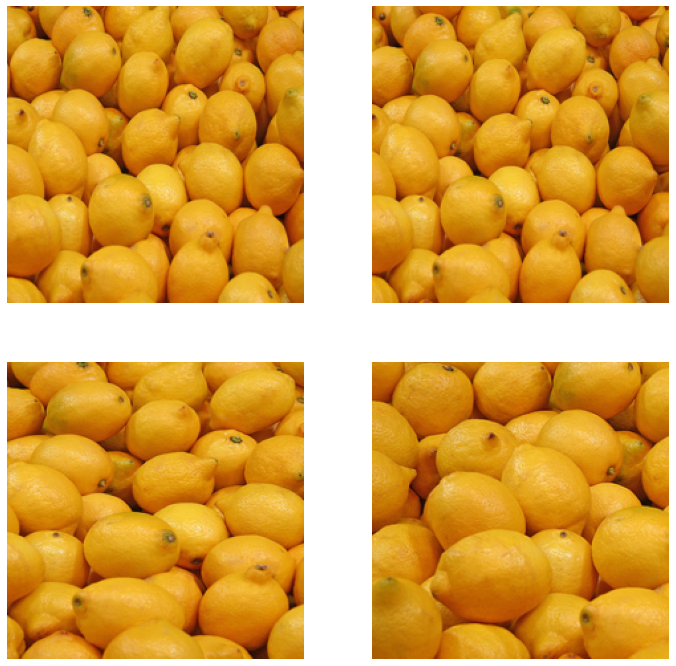

In [5]:
crops = [transforms.RandomResizedCrop(224)(image) for _ in range(4)]

plt.figure(figsize=(12, 12))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(crops[i])
    plt.axis('off')

plt.show()

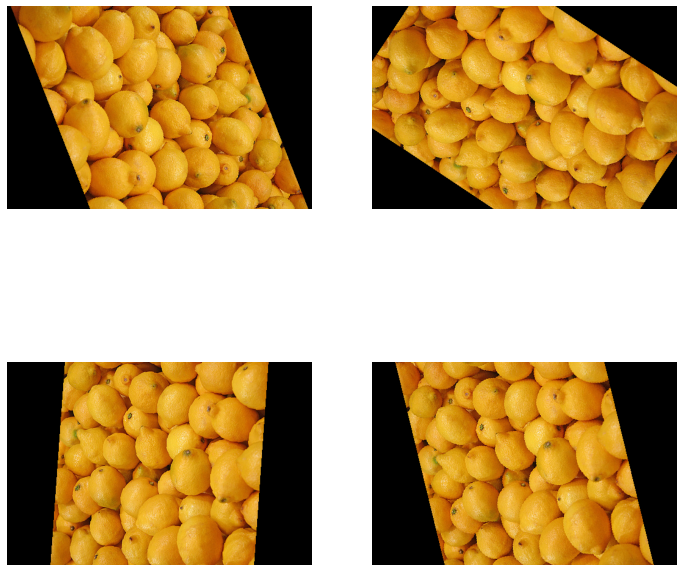

In [6]:
rotations = [transforms.RandomRotation(180)(image) for _ in range(4)]

plt.figure(figsize=(12, 12))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(rotations[i])
    plt.axis('off')

plt.show()

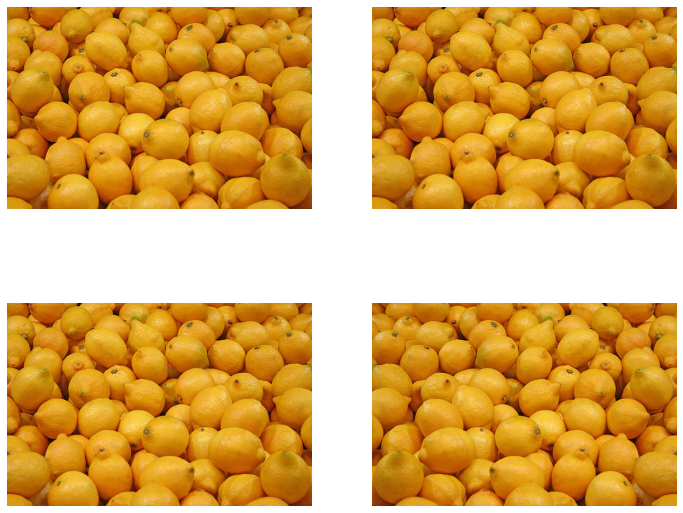

In [7]:
flips = [transforms.transforms.RandomHorizontalFlip()(image) for _ in range(4)]

plt.figure(figsize=(12, 10))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(flips[i])
    plt.axis('off')

plt.show()

Nous pouvons aussi combiner ces transformations :

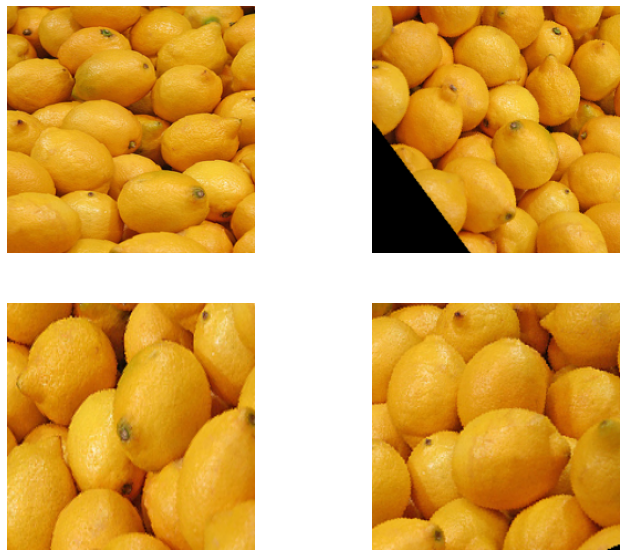

In [8]:
augmentation = transforms.Compose([
    transforms.RandomRotation(90),
    transforms.RandomResizedCrop(224),
    transforms.transforms.RandomHorizontalFlip()
])
aug = [augmentation(image) for _ in range(4)]

plt.figure(figsize=(12, 10))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(aug[i])
    plt.axis('off')

plt.show()

Nous avons réussi à construire une infinité d'images à partir d'un unique exemple ! Observons maintenant les effets sur l'apprentissage que donne cette méthode.

### a. Un premier modèle sans data augmentation

Nous allons dans un premier temps reprendre le modèle du TP 5 (le code est fourni ci-dessous). Ce modèle nous permettra "d'étalonner" les performances d'apprentissage sans aucune régularisation. Nous réutiliserons également ces résultats dans les sections *dropout* ou encore *batchnorm*.

In [25]:
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import numpy as np

In [10]:
if not book:
    # label names
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    transform = transforms.Compose(
      [
          transforms.ToTensor(),
          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
      ]
    )

    batch_size = 128

    #root_directory where images are.
    trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

    trainloader = DataLoader(
      trainset, batch_size=batch_size
    )

    testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    testloader = DataLoader(
      testset, batch_size=batch_size, shuffle=True
    )

    print('Nb test batchs:', len(testloader))

Files already downloaded and verified
Files already downloaded and verified
Nb test batchs: 79


In [12]:
def imshow(images, labels, predicted=None):
    plt.figure(figsize=(15, 10))
    for idx in range(8):
        plt.subplot(2, 4, idx+1)
        plt.axis('off')
        img = (images[idx] * 0.224 + 0.456)#/ 2 + 0.5  # unnormalize
        npimg = img.numpy()
        plt.axis('off')
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        title = str(classes[labels[idx]]) + \
        ('' if predicted is None else ' - ' + str(classes[predicted[idx]]))
        plt.title(title)
        
    plt.show()

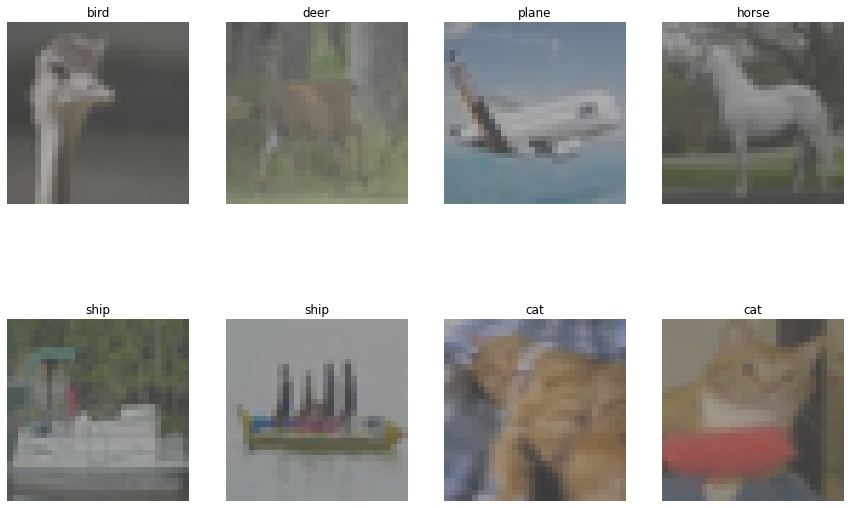

In [13]:
if not book:
    dataiter = iter(testloader)
    images, labels = dataiter.next()

    # show images
    imshow(images[:8], labels[:8])

In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc(x)
        return x

In [16]:
criterion = nn.CrossEntropyLoss()

In [20]:
def test(model, loader, title):
    model.eval()  # on passe le modele en mode evaluation
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            # images = images.cuda()
            # labels = labels.cuda()
            outputs = model(images)
            predicted = torch.nn.functional.softmax(outputs, dim=1).max(dim=1)
            
            total += labels.size(0)
            correct += (predicted[1] == labels).sum().item()
            
    model.train()  # on remet le modele en mode apprentissage
    print('Accuracy du modele sur le jeu de ', title, ': %.2f' % (correct / total))
    return correct / total
  
def loss_eval(model, loader, title):
    model.eval()  # on passe le modele en mode evaluation
    running_loss = 0.
    total = 0.
    with torch.no_grad():
        for data in loader:
            images, labels = data
            # images = images.cuda()
            # labels = labels.cuda()
            outputs = model(images)

            total += 1.
            running_loss += criterion(outputs, labels).item()

    model.train()  # on remet le modele en mode apprentissage
    print('Loss du modele sur le jeu de ', title, ': %.2f' % (running_loss / total))
    return (running_loss / total)


In [ ]:
if not book:
    model = Net()
    # model = model.cuda()

    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)

    eval_frequency=2

    loss_history, \
    valid_loss_history, \
    acc_history, \
    val_acc_history = train(model, criterion, optimizer, n_epoch=30)

In [27]:
def plot_loss(loss_history, valid_loss_history, acc_history, val_acc_history):
    plt.figure()
    plt.plot([i*eval_frequency for i in range(1, len(loss_history)+1)], loss_history, 
             label='Train loss')
    plt.plot([i*eval_frequency for i in range(1, len(loss_history)+1)], valid_loss_history, 
             label='Validation loss')
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot([i*eval_frequency for i in range(1, len(acc_history)+1)], acc_history, 
             label='Train Accuracy')
    plt.plot([i*eval_frequency for i in range(1, len(acc_history)+1)], val_acc_history, 
             label='Validation Accuracy')
    plt.legend()
    plt.show()

In [ ]:
if not book:
    plot_loss(loss_history, valid_loss_history, acc_history, val_acc_history)

### b. Un modèle avec data augmentation

Attention, les effets de ces stratégies deviennent d'autant plus visibles qu'on utilise des modèles véritablement complexes. Les effets ici resteront limités car le modèle est pensé pour que l'apprentissage soit "rapide".

---
<span style="color:blue">**Exercice :**</span> **Construisez un $\texttt{trainloader}$ qui réalise des *flips* horizontaux ainsi que des rotation aléatoire d'au plus $45^\circ$. Attention, n'oubliez pas que les données doivent être transformées en tenseur et normalisées comme au-dessus.**

---

In [31]:
if not book:
    ####### Complete this part ######## or die ####################
    transform = transforms.Compose(
          [
              transforms.ToTensor(),
              transforms.RandomHorizontalFlip(),
              transforms.RandomRotation(45),
              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
          ]
      )

    trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

    trainloader = DataLoader(
      trainset, batch_size=batch_size
    )
    ###############################################################

Files already downloaded and verified


In [ ]:
if not book:
    model = Net()
    # model = model.cuda()

    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)

    eval_frequency=2

    loss_history_a, \
    valid_loss_history_a, \
    acc_history_a, \
    val_acc_history_a = train(model, criterion, optimizer, n_epoch=30)

In [ ]:
if not book:
    plot_loss(loss_history_a, valid_loss_history_a, acc_history_a, val_acc_history_a)

## IV. Le *dropout*

L'idée du *dropout* est de perturber l'apprentissage en mettant aléatoirement certains neurones de notre réseau à $0$. Ainsi, le modèle, afin de minimiser l'erreur, est obligé d'exploiter de l'information provenant de plusieurs neurones : cette redondance limite l'effet de surapprentissage très lié à la capacité du modèle à exploiter le bruit des données, bruit qui par définition n'offre pas de redondance.

Notons $\sigma$ une non-linéarité et $w_{ij}, b_{ij}$ les paramètres de la couche $i$ et du neurone $j$ de notre réseau de neurones. Nous avons donc pour la couche $i$ et son neurone $j$ :
$$\sigma(\langle w_{ij}, z\rangle +b_{ij}),$$
où $z$ est la sortie de la couche précédente. L'idée du *Dropout* est de considérer un vecteur $\delta$ tel que $\delta_i\sim \text{Bernoulli}(1-p)$ où $p$ est le paramètre de *dropout* si $p=0$ alors le *dropout* est désactivé, et si $p$ est proche de $1$ alors aucune information ne passe. Une couche de dropout est :
$$\text{do}(z)=\frac{\delta \odot z}{1-p}, $$
où $\odot$ est la multiplication élément par élément. Le dénominateur permet de garantir que "l'amplitude" du vecteur sortant du *dropout* est la même avec ou sans *dropout*. Plus rigoureusement, nous avons : 
$$\mathbb{E}\Big[\frac{\delta_i}{1-p}\Big]=1.$$
Le dropout est désactivé lorsqu'on utilise le modèle pour faire des prédictions (et sa normalisation également). En reprenant notre couche $i$, tous ses neurones $j$ ont la forme suivante :

$$\sigma(\langle w_{ij}, \text{do}(z)\rangle +b_{ij}),$$

In [ ]:
if not book:
    # on reprend le dataset sans data augmentation
    transform = transforms.Compose(
      [
          transforms.ToTensor(),
          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
      ]
    )

    batch_size = 128

    #root_directory where images are.
    trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

    trainloader = DataLoader(
      trainset, batch_size=batch_size
    )

---
<span style="color:blue">**Exercice :**</span> **Modifiez le modèle proposé ci-dessous en intégrant une couche de *dropout* de paramètre $p=0.2$.**

---

In [ ]:
####### Complete this part ######## or die ####################
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.dropout = nn.Dropout(p=0.2) #########
        self.fc = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x) #########
        x = self.fc(x)
        return x
###############################################################

In [ ]:
if not book:
    model = Net()
    model = model.cuda()

    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)

    eval_frequency=2

    loss_history_do, \
    valid_loss_history_do, \
    acc_history_do, \
    val_acc_history_do = train(model, criterion, optimizer, n_epoch=30)

In [ ]:
if not book:
    plot_loss(loss_history_do, valid_loss_history_do, acc_history_do, val_acc_history_do)

## V. La *batch normalization*

La batch normalization est une autre technique de régularisation qui n'a cependant, à première vue, rien à voir avec la régularisation. Ses effets sont encore mal compris et sont probablement liés à la régularisation implicite qui dépend de l'optimiseur lui-même (comme nous allons le voir plus bas). La batch normalization ne fonctionne que si les données arrivent par batch de taille supérieure à 1. Nous allons voir une manière standard de faire de la *batch normalization* mais il est à noter que la couche est généralement ultra-configurable et beaucoup de ses composantes peuvent être désactivées. Une couche est décrite par l'équation suivante : 

$$\text{bn}(z)=\frac{z-\mathbb{E}\big[z\big]}{\sqrt{\text{Var}(z)+\epsilon}}\odot \gamma+\beta,$$
où $z$ est un batch de données, $\gamma$ et $\beta$ sont des vecteurs dont la dimension est celle d'une donnée de $z$ et dont les opérations sont appliquées élément par élément dans $z$. L'espérance et la variance sont calculées à partir du batch mais peuvent conserver une inertie des batchs précédents. Lorsque notre modèle passe en mode prédiction, on réutilise les statistiques de moyenne et de variance obtenues lors de l'apprentissage.

**Attention,** certains objets $\texttt{pytorch}$ demande si leur entrée sera un vecteur (1d), une image (2d), etc. C'est le cas de la *batch normalization* avec notamment *BatchNorm1d* ou *BatchNorm2d*, etc.

---
<span style="color:blue">**Exercice :**</span> **Proposez ci-dessous une modification permettant d'intégrer une couche de *batch normalization*.**

---

In [ ]:
####### Complete this part ######## or die ####################
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32 * 5 * 5, 120)
        self.bn = nn.BatchNorm2d(32) ##########
        self.fc2 = nn.Linear(120, 84)
        self.fc = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.bn(x) ##############
        x = x.view(-1, 32 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc(x)
        return x
###############################################################

In [ ]:
if not book:
    model = Net()
    model = model.cuda()

    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)

    eval_frequency=2

    loss_history_do, \
    valid_loss_history_do, \
    acc_history_do, \
    val_acc_history_do = train(model, criterion, optimizer, n_epoch=30)

In [ ]:
if not book:
    plot_loss(loss_history_do, valid_loss_history_do, acc_history_do, val_acc_history_do)

## VI. Sparse representation

## VII. Les ensembles

## VIII. Le biais implicite de SGD

Il se trouve qu'une des raisons pouvant expliquer le succès des réseaux de neurones est liées à la manière dont on les optimise. On parle soucent de "biais implicite" lié à l'optimiseur qui entraînerait une régularisation par lui-même. Nous allons ici observer cet effet sur un jeu de données synthétique.

In [ ]:
def make_dec_func(model):
    def dec_func(X):
        data = torch.from_numpy(X).float()
        Z = model(data)
        return Z
    return dec_func

def make_pred_func(model):
    dec_func = make_dec_func(model)

    def predict(X):
        output = dec_func(X)
        return output.argmax(dim=-1)

    return predict

def plot(X, y, clf=None):
    plt.figure(figsize=(14, 8))
    # plt.xticks(())
    # plt.yticks(())
    if clf is not None:
        clf = make_pred_func(clf)
        XX, YY = np.mgrid[-1:1:1000j, -1:1:1000j]
        Z = clf(np.c_[XX.ravel(), YY.ravel()])
        plt.title('Les données et la frontière de décision')
        # Put the result into a color plot
        Z = Z.reshape(XX.shape)
        plt.pcolormesh(XX, YY, Z, cmap=plt.cm.Paired, shading='auto')
    else:
        plt.title('Les données')

    plt.xlim(-1, 1)
    plt.ylim(-1, 1)

    plt.scatter(X[:, 0], X[:, 1], c=y)

    plt.show()

In [ ]:
def sample_data(size=200):
    X = np.random.uniform(-1, 1, size=(size, 2))
    y = X[:, 0]**3 < X[:, 1]
    return X, y
X, y = sample_data()

plot(X, y)

In [ ]:
class SyntheticDataset(TorchDataset):
    def __init__(self, X, y):
        self.dataset, self.label = X, y

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        return torch.from_numpy(self.dataset[idx]).float(), int(self.label[idx])
    
dataset = SyntheticDataset(X, y)

In [ ]:
def fullyconnected_layer(in_f, out_f):
    """
    " this function returns a fully connected layer with batchnorm
    """
    return nn.Sequential(
        nn.Linear(in_f, out_f),
        nn.BatchNorm1d(out_f),
        nn.ReLU()
    )

class FullyConnectedNetwork(nn.Module):
    def __init__(self, n_labels=2, n_input=2, architecture=(2,)):
        """
        " n_labels is the dimension of the output
        " n_input is the dimension of the input
        " architecture describes the series of hidden layers
        """
        super(FullyConnectedNetwork, self).__init__()

        layer_size = [n_input] + [i for i in architecture]

        layers = [
            fullyconnected_layer(in_f, out_f) for in_f, out_f in zip(layer_size, layer_size[1:])
        ]
        self.layers = nn.Sequential(*layers)
        self.fc = nn.Linear(architecture[-1], n_labels)

    def forward(self, x):
        x = self.layers(x)
        x = self.fc(x)
        return x

In [ ]:
def train_and_plot(lr=0.005, batch_size=200, epochs=5000, logs=10):
    model = FullyConnectedNetwork(architecture=tuple(10 for _ in range(10)))
    # model.cuda()
    
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.)
    criterion = nn.CrossEntropyLoss()
    
    train_loader = DataLoader(dataset, shuffle=True, batch_size=batch_size, num_workers=0)
    
    loss_history = []
    running_loss = 0.0
    for e in range(epochs):
        for idx, data in enumerate(train_loader):
            inputs, labels = data
            # labels = labels.cuda()
            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            running_loss += loss.item()
            if idx % logs == logs - 1:  # print every 2000 mini-batches
                print('\r[%d, %5d] loss: %.3f' % (e + 1, idx + 1, running_loss / logs), end="")
                loss_history.append(running_loss / logs)
                running_loss = 0.0

            loss.backward() # on calcule le gradient
            optimizer.step() # on fait un pas d'optimisation
    print('\r************* Training done! *************')
    plt.plot(loss_history)
    plt.title('Loss')
    plt.show()
    plot(X, y, model)

Tester batch size : 5 (et epochs 1000).... BS 5+ LR 0.1

In [ ]:
if not book:
    train_and_plot(lr=0.001, batch_size=20, epochs=1000, logs=1)